In [84]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.stats as st
import numpy as np
import scipy as sp
import sklearn
import sklearn.isotonic
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.metrics import auc, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

from elevation import util

def compare_x(x, y):
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    ax1.scatter(x[0], y[0])
    ax2.scatter(x[1], y[1])

def compare_y(x1, x2, title1="x1", title2="x2"):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_size_inches(20, 10)
    ax1.plot(np.arange(x1.shape[0]), x1)
    ax1.set_title(title1)
    ax2.plot(np.arange(x2.shape[0]), x2)
    ax2.set_title(title2)

def compare_hist(x1, x2, num_bins=100, label1="x1", label2="x2", max_mean=False, min_mean=False):
    # plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.figure(figsize=(16, 12))
    minf = np.mean if min_mean else np.min
    maxf = np.mean if max_mean else np.max
    min_x = minf(map(minf, (x1, x2)))
    max_x = maxf(map(maxf, (x1, x2)))
    bins = np.linspace(min_x, max_x, num_bins)
    plt.hist(x1, bins, alpha=0.5, label=label1)
    plt.hist(x2, bins, alpha=0.5, label=label2)
    plt.legend(loc='upper right')

def compare_box(pairs, title="Compare", margins=None):
    f, axes = plt.subplots(len(pairs), sharex=True)
    if len(pairs) == 1: axes = [axes]
    f.set_size_inches(6, 6*len(pairs))
    for i in range(len(pairs)):
        ax = axes[i]
        ax.boxplot(pairs[i])
        minf = np.min
        maxf = np.max
        if margins is not None:
            min_x = minf(map(minf, pairs[i]))
            max_x = maxf(map(maxf, pairs[i]))
            ax.set_ylim([min_x - margins[i], max_x + margins[i]])

def compare_scatter(pairs, title="Compare", margins=None):
    f, axes = plt.subplots(len(pairs), sharex=True)
    if len(pairs) == 1: axes = [axes]
    f.set_size_inches(6, 6*len(pairs))
    for i in range(len(pairs)):
        ax = axes[i]
        ax.scatter(*pairs[i], alpha=0.5)
        minf = np.min
        maxf = np.max
        if margins is not None:
            min_x = minf(map(minf, pairs[i]))
            max_x = maxf(map(maxf, pairs[i]))
            ax.set_ylim([min_x - margins[i], max_x + margins[i]])

def fit_lasso(ind_keep, X, y, y_transf):
    seed = 12345
    normX = True

    # what been using up until 9/12/2016
    # clf = sklearn.linear_model.LassoCV(cv=10, fit_intercept=True, normalize=True)

    # from IPython.core.debugger import Tracer; Tracer()()
    # now using this:
    kfold = StratifiedKFold(y[ind_keep].flatten()==0, 10, random_state=seed)
    clf = sklearn.linear_model.LassoCV(cv=kfold, fit_intercept=True, normalize=(~normX),
                                       n_jobs=10, random_state=seed)
    if normX:
        clf = sklearn.pipeline.Pipeline([['scaling', sklearn.preprocessing.StandardScaler()], ['lasso', clf]])

    # y_transf2 = st.boxcox(y[ind_keep] - y[ind_keep].min() + 0.001)[0]
    # assert np.allclose(y_transf, y_transf2)
    # y_transf = st.boxcox(y[ind_keep] + 0.00000001)[0]
    # y_transf = y[ind_keep]
    clf.fit(X[ind_keep], y_transf)
    return clf

def fit_lr(X, y):
    clf = LogisticRegression(fit_intercept=True, solver='lbfgs')
    clf.fit(X, y)
    return clf

In [170]:
X1 = np.array([1,2,3,5,7,4,9]).reshape(7,1)
y = np.array([1,1,1,0,1,0,0])

# for X in [X1, X2]:
sign = -1
for i in range(100):
    rs = np.random.RandomState(i)
    mean = np.random.randint(-100, 100)
    scale = np.random.randint(-10, 10)
    # X = X1
    X = X1*scale + mean
    # X = np.random.permutation(X1)
    clf = LogisticRegression(fit_intercept=True, solver='lbfgs', random_state=rs)
    clf.fit(X, y)
    new_sign = sp.stats.spearmanr(clf.predict_proba(X).T[1], X.T[0])[0]
    if sign != new_sign:
        print sign, new_sign, i
        break

-1 1.0 2


In [62]:
ind_keep1 = util.from_temp("lrs_ind_keep")

# guideseq predictions
X1 = util.from_temp("lrs_X")

# cd33 predictions
Xtest1 = util.from_temp("lrs_Xtest")

# guideseq_data['GUIDE-SEQ Reads']
y_raw1 = util.from_temp("lrs_y_raw")
y1 = util.from_temp("lrs_y")

X2 = util.from_temp("lrs_X_new")
Xtest2 = util.from_temp("lrs_Xtest_new")
y_raw2 = util.from_temp("lrs_y_raw_new")
y2 = util.from_temp("lrs_y_new")
ind_keep2 = util.from_temp("lrs_ind_keep_new")

# same for both
cd33_data = util.from_temp("cd33")[0]
Y_bin = cd33_data['Day21-ETP-binarized'].values
Y = cd33_data['Day21-ETP'].values

# tests
print Xtest1.shape, Xtest2.shape
print np.allclose(Xtest1, Xtest2)

(4853L, 24L) (4853L, 24L)
True


In [16]:
print np.sum(y1 == 0), y1.shape[0]
print np.sum(y2 == 0), y2.shape[0]
print np.sum(y_raw1[ind_keep1] == 0.0), np.sum(ind_keep1), float(np.sum(y_raw1[ind_keep1] == 0.0))/np.sum(ind_keep1)
print np.sum(y_raw2[ind_keep2] == 0.0), np.sum(ind_keep2), float(np.sum(y_raw2[ind_keep2] == 0.0))/np.sum(ind_keep2)
print y_raw1[ind_keep1].min(), y_raw1[ind_keep1].max()
print y_raw2[ind_keep2].min(), y_raw2[ind_keep2].max()

0 709
0 773
355 709 0.500705218618
387 773 0.50064683053
0.0 1.0
0.0 1.0


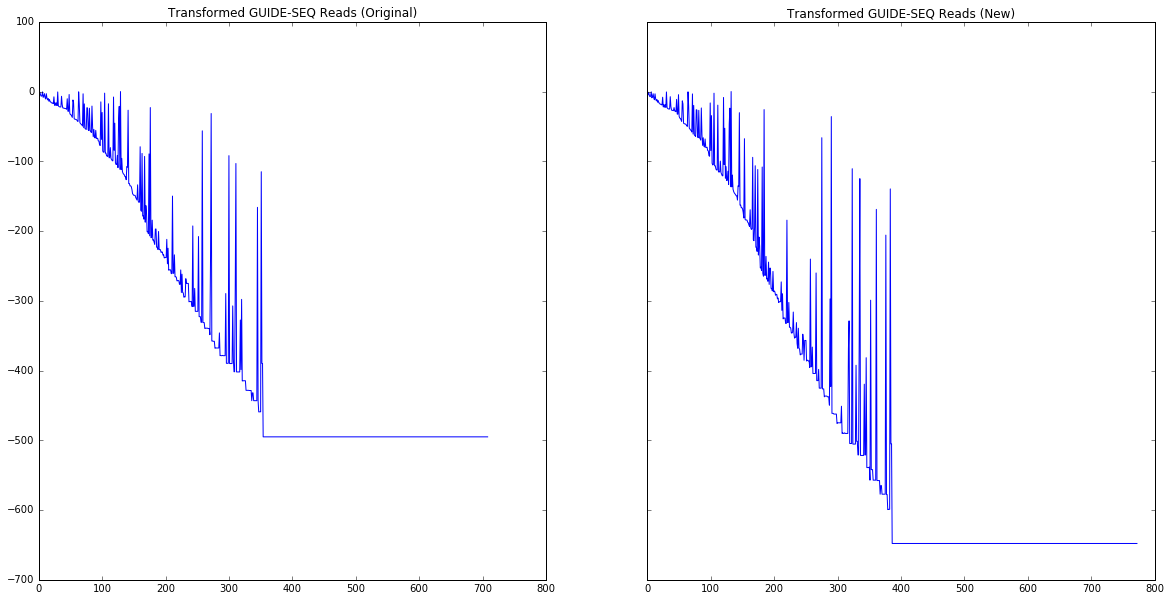

In [177]:
compare_y(y1, y2, "Transformed GUIDE-SEQ Reads (Original)", "Transformed GUIDE-SEQ Reads (New)")

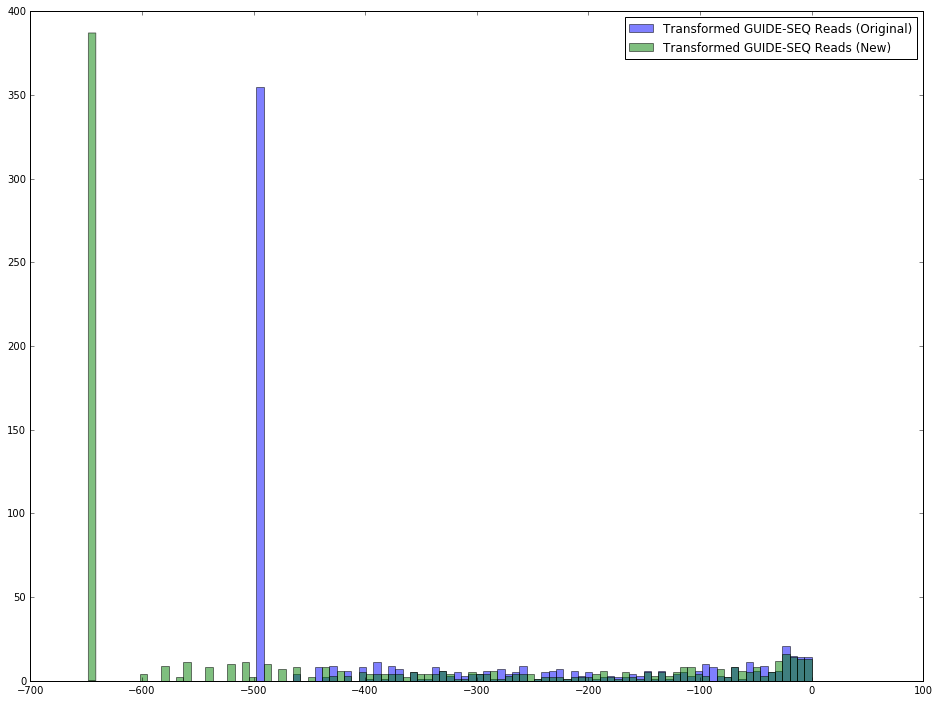

In [178]:
compare_hist(y1, y2, 100, "Transformed GUIDE-SEQ Reads (Original)", "Transformed GUIDE-SEQ Reads (New)")

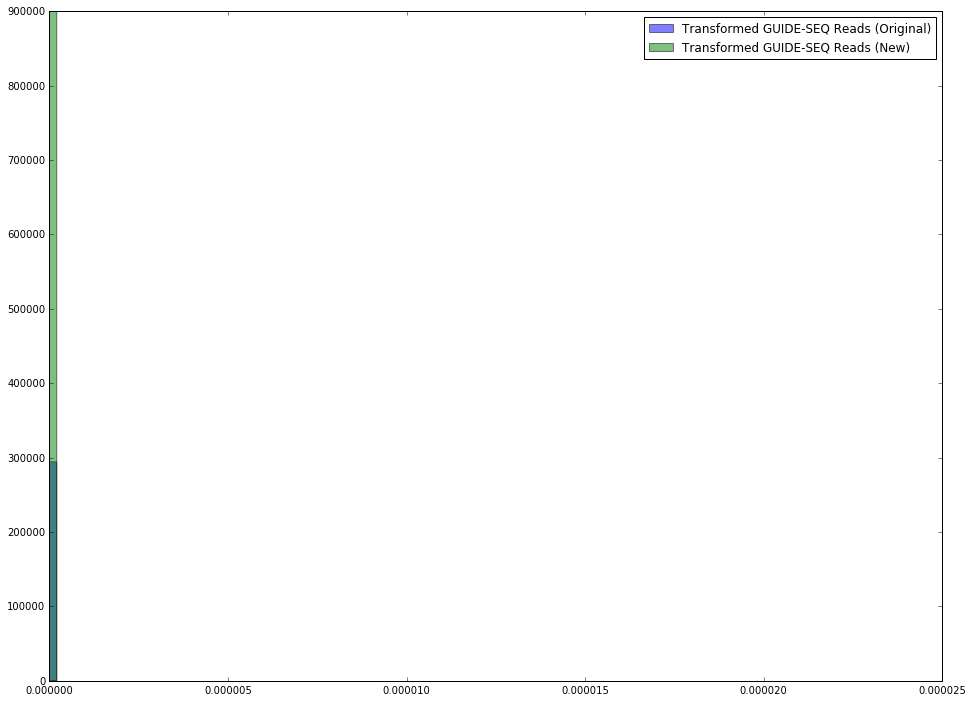

In [97]:
compare_hist(y_raw1, y_raw2, 100, "GUIDE-SEQ Reads (Original)", "GUIDE-SEQ Reads (New)", max_mean=True)

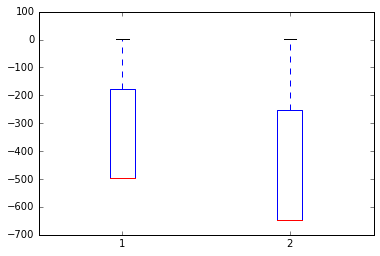

In [120]:
compare_box(y1, y2)

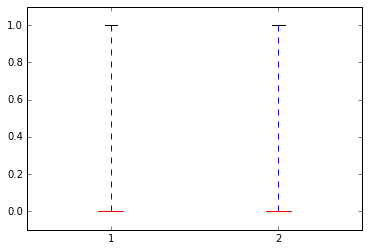

In [121]:
compare_box(y_raw1, y_raw2, margin=0.1)

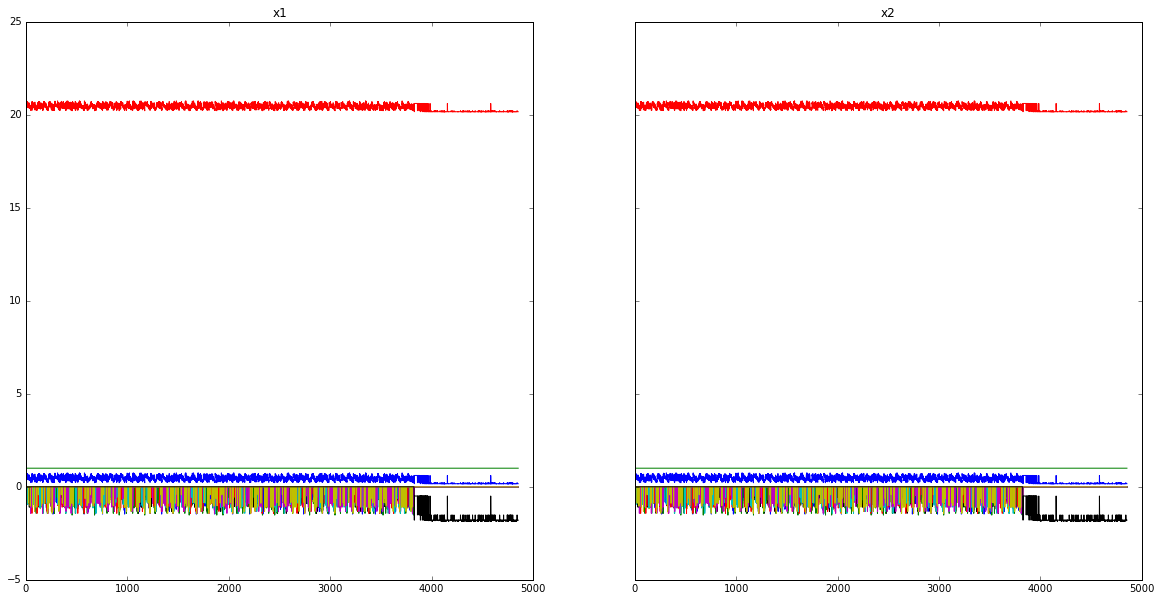

In [179]:
compare_y(Xtest1, Xtest2)

In [85]:
lasso1 = fit_lasso(ind_keep1, X1, y_raw1, y1)
lassopred1 = lasso1.predict(Xtest1)
lr_model1 = fit_lr(lassopred1[:, None], Y_bin)
predprob1 = lr_model1.predict_proba(lassopred1[:, None])[:, 1]
print sp.stats.spearmanr(predprob1, lassopred1)[0]

C:\Users\v-huelib\AppData\Local\Continuum\Anaconda2\envs\elevation\lib\site-packages\scikit_learn-0.17.1-py2.7-win-amd64.egg\sklearn\linear_model\coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0


In [86]:
lasso2 = fit_lasso(ind_keep2, X2, y_raw2, y2)
lassopred2 = lasso2.predict(Xtest2)
lr_model2 = fit_lr(lassopred2[:, None], Y_bin)
predprob2 = lr_model2.predict_proba(lassopred2[:, None])[:, 1]
print sp.stats.spearmanr(predprob2, lassopred2)[0]

-1.0


C:\Users\v-huelib\AppData\Local\Continuum\Anaconda2\envs\elevation\lib\site-packages\scikit_learn-0.17.1-py2.7-win-amd64.egg\sklearn\linear_model\coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [87]:
print "train1", r2_score(lasso1.predict(X1[ind_keep1]), y1)
print "test1", r2_score(lasso1.predict(Xtest1), Y)

print "train2", r2_score(lasso2.predict(X2[ind_keep2]), y2)
print "test2", r2_score(lasso2.predict(Xtest2), Y)

train1 0.598479755376
test1 -1.84344400678
train2 0.582246338995
test2 -38.5517444875


In [88]:
print "train1", r2_score(lasso1.predict(X1[ind_keep1]), y_raw1[ind_keep1])
print "test1", r2_score(lasso1.predict(Xtest1), Y)

print "train2", r2_score(lasso2.predict(X2[ind_keep2]), y_raw2[ind_keep2])
print "test2", r2_score(lasso2.predict(Xtest2), Y)

train1 -5.05690124671
test1 -1.84344400678
train2 -5.4042531868
test2 -38.5517444875


In [81]:
# w/o boxcot
print "train1", r2_score(lasso1.predict(X1[ind_keep1]), y_raw1[ind_keep1])
print "test1", r2_score(lasso1.predict(Xtest1), Y)

print "train2", r2_score(lasso2.predict(X2[ind_keep2]), y_raw2[ind_keep2])
print "test2", r2_score(lasso2.predict(Xtest2), Y)

train1 -6.16074819616
test1 -51.2496006183
train2 -3.29721390878
test2 -30.2288709493


In [242]:
np.sum(predprob1 > 0.5), np.sum(predprob1 < 0.5)

(2172, 2681)

In [243]:
np.sum(predprob2 > 0.5), np.sum(predprob2 < 0.5)

(1952, 2901)

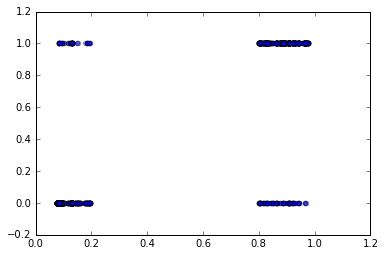

In [246]:
plt.scatter(predprob1[(predprob1 < 0.2) | (predprob1 > 0.8)], Y_bin[(predprob1 < 0.2) | (predprob1 > 0.8)], alpha=0.3)

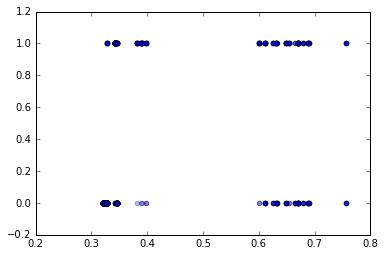

In [249]:
plt.scatter(predprob2[(predprob2 < 0.4) | (predprob2 > 0.6)], Y_bin[(predprob2 < 0.4) | (predprob2 > 0.6)], alpha=0.3)

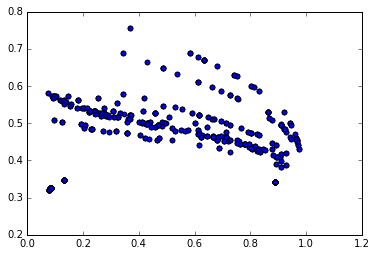

In [89]:
plt.scatter(predprob1, predprob2, alpha=0.3)

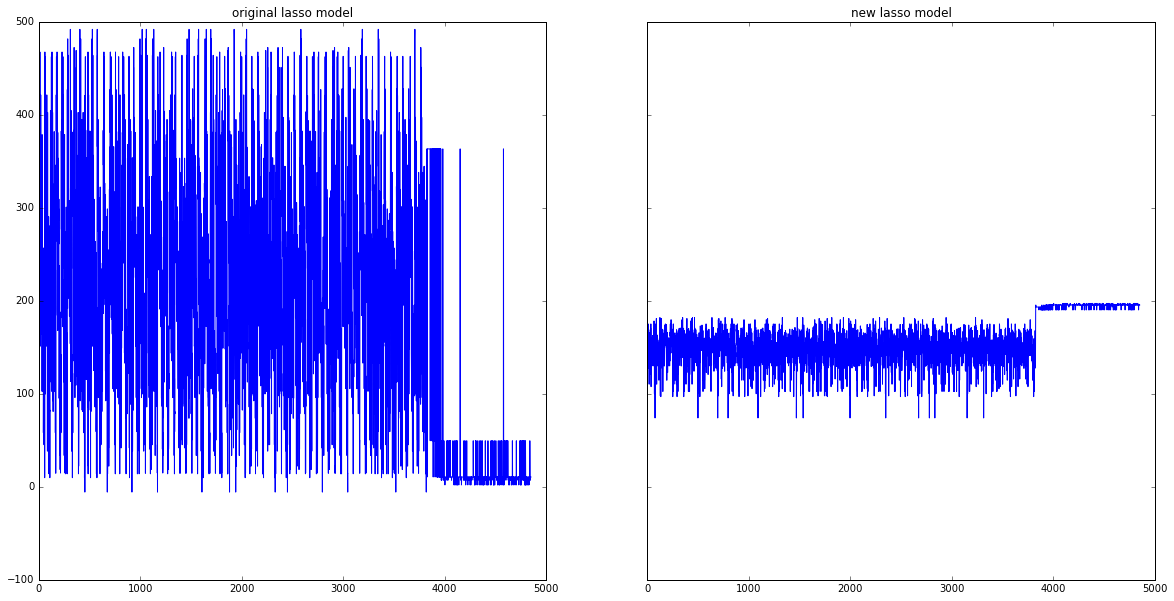

In [209]:
compare_y(lasso1.predict(Xtest1), lasso2.predict(Xtest2), "original lasso model", "new lasso model")

In [191]:
print lasso1.named_steps['lasso'].intercept_
print lasso2.named_steps['lasso'].intercept_
print lasso1.named_steps['lasso'].coef_[:6]
print lasso2.named_steps['lasso'].coef_[:6]

-343.950841186
-451.399519329
[-13.24589631  -7.80548069  -7.64820592  -2.9875851    8.06403189   0.        ]
[ 12.34510558   9.44959178   0.          -0.          19.42050775   0.        ]


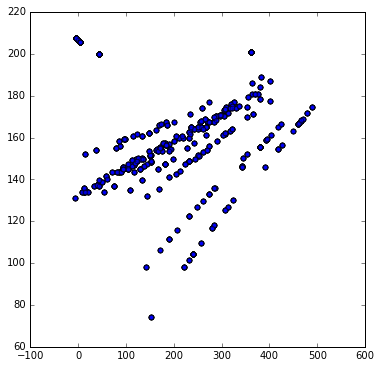

In [90]:
compare_scatter([[lasso1.predict(Xtest1), lasso2.predict(Xtest2)]])

In [208]:
print min(lasso1.predict(Xtest2)), max(lasso1.predict(Xtest2))

-5.67185691699 491.893086509


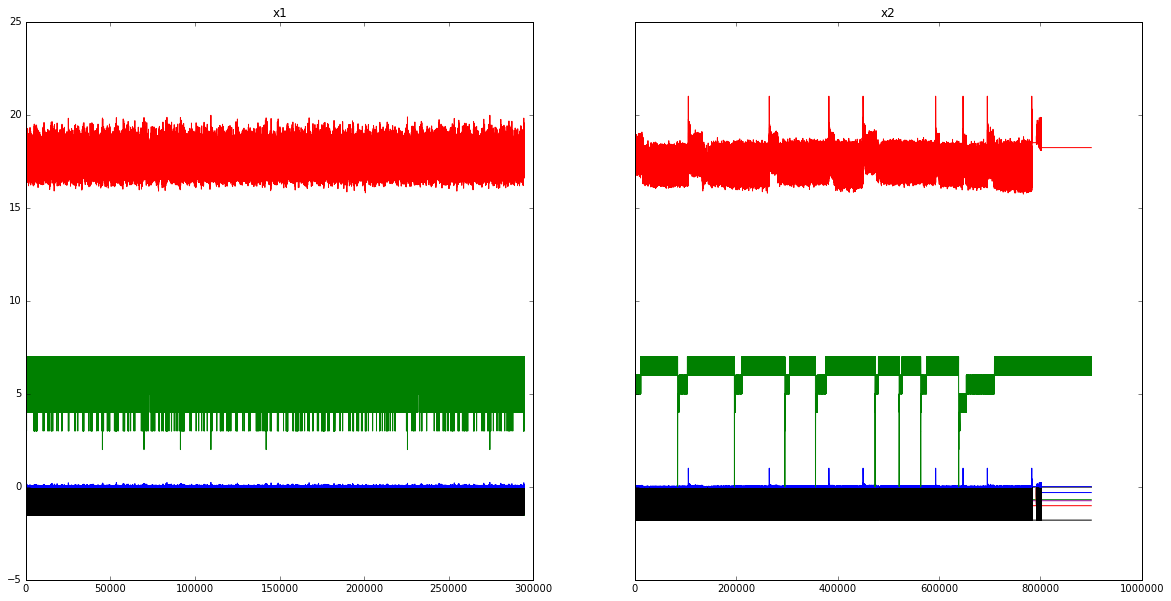

In [136]:
compare_y(X1, X2)

In [128]:
assert X1.shape[1] == X2.shape[1]
print X1[ind_keep1].shape, X2[ind_keep2].shape

(709L, 24L) (773L, 24L)


In [133]:
X_ind_keep1 = X1[ind_keep1]
X_ind_keep2 = X2[ind_keep2]

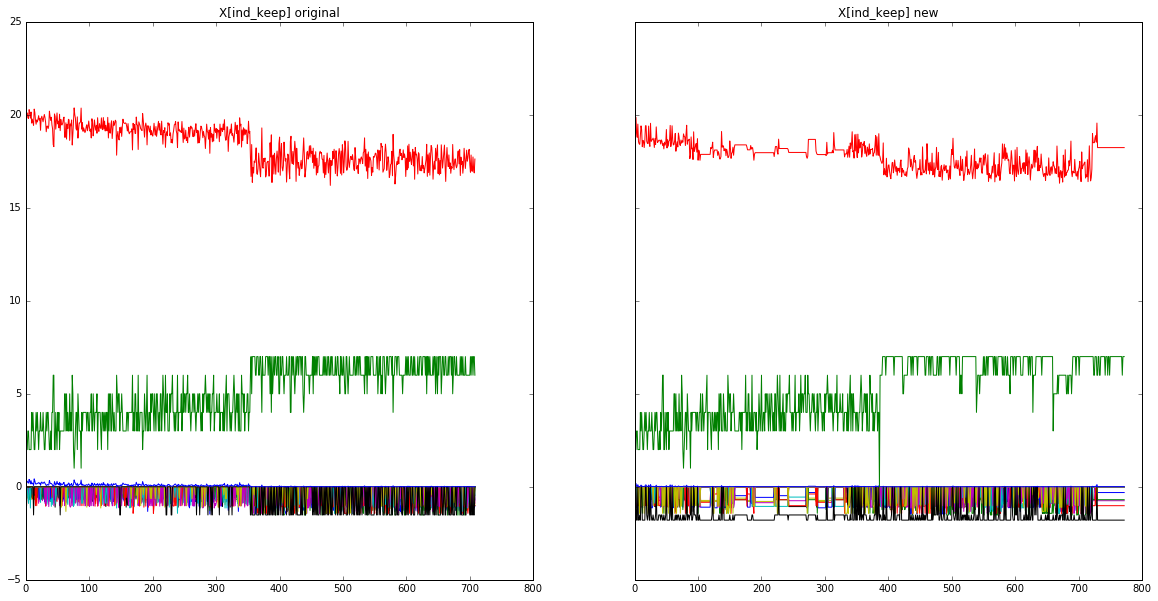

In [211]:
compare_y(X_ind_keep1, X_ind_keep2, "X[ind_keep] original", "X[ind_keep] new")

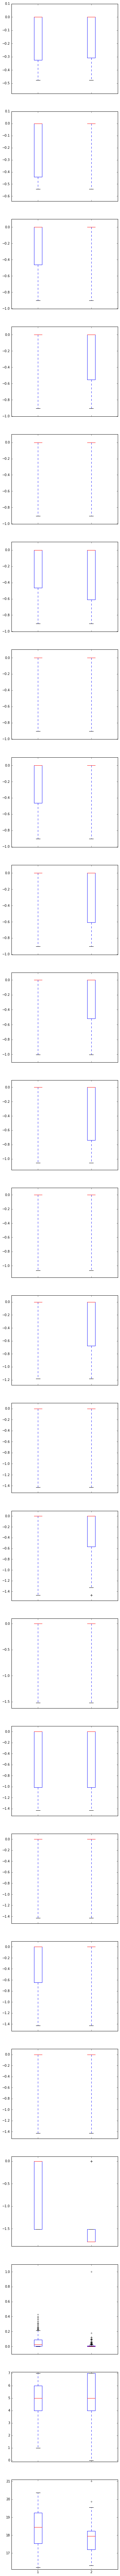

In [157]:
compare_range = range(X_ind_keep1.shape[1])
margins = [0.1 for i in compare_range]
compare_box([
        (X_ind_keep1[:, j], X_ind_keep2[:, j]) for j in compare_range
], margins=margins)


In [168]:
scaler = sklearn.preprocessing.StandardScaler()

print scaler.fit_transform(X_ind_keep1[:, 0])[:100]
print scaler.fit_transform(X_ind_keep2[:, 0])[:100]

[ 0.85887924 -0.86096169  0.85887924 -0.86096169 -0.77510766 -0.77510766
  0.85887924  0.85887924  0.85887924 -0.77510766 -1.66439225 -0.86096169
  0.85887924  0.85887924  0.85887924 -0.86096169 -0.86096169 -0.77510766
 -0.77510766  0.85887924  0.85887924  0.85887924 -0.86096169  0.85887924
  0.85887924 -0.77510766 -0.86096169 -0.77510766 -0.86096169  0.85887924
  0.85887924  0.85887924  0.85887924  0.85887924 -1.66439225 -1.66439225
  0.85887924 -0.86096169  0.85887924 -0.86096169  0.85887924  0.85887924
 -1.66439225 -1.66439225 -1.66439225  0.85887924  0.85887924 -0.86096169
  0.85887924  0.85887924 -1.66439225  0.85887924  0.85887924  0.85887924
  0.85887924 -1.66439225  0.85887924  0.85887924  0.85887924  0.85887924
 -0.77510766 -1.66439225 -1.66439225 -1.66439225 -1.66439225  0.85887924
 -1.66439225  0.85887924  0.85887924 -1.66439225  0.85887924 -0.77510766
 -0.86096169 -1.66439225 -0.86096169  0.85887924  0.85887924  0.85887924
 -0.77510766 -0.86096169  0.85887924  0.85887924 -1

C:\Users\v-huelib\AppData\Local\Continuum\Anaconda2\envs\elevation\lib\site-packages\scikit_learn-0.17.1-py2.7-win-amd64.egg\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\v-huelib\AppData\Local\Continuum\Anaconda2\envs\elevation\lib\site-packages\scikit_learn-0.17.1-py2.7-win-amd64.egg\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\v-huelib\AppData\Local\Continuum\Anaconda2\envs\elevation\lib\site-packages\scikit_le

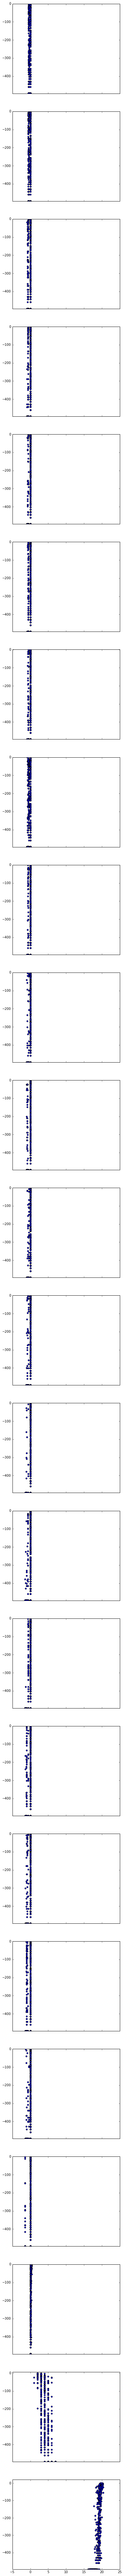

In [205]:
compare_range = range(X_ind_keep1.shape[1])
margins = [0.1 for i in compare_range]
pairs1 = [(X_ind_keep1[:, j], y1) for j in compare_range]
pairs2 = [(X_ind_keep2[:, j], y2) for j in compare_range]

compare_scatter(pairs, margins=margins)